In [2]:
library(FactoMineR)
library(factoextra)#fviz_eig
library(psych)
library(GPArotation)
library(ggplot2)
library(corrplot)
library(RColorBrewer)
library(stats)
library(tidyverse)
library(reshape)#melt
library(nFactors)#optimal number of components
library(psychTools)
library(pheatmap)


载入程辑包：'psychTools'


The following object is masked from 'package:dplyr':

    recode


Warning message:
"程辑包'pheatmap'是用R版本4.1.3 来建造的"


In [3]:
extended_bassAckward <- function (r, num.comp = 1, fm = "fa")
{
  comp.corr <- list()
  cong <- list()
  comp.load <- list()
  pcas <- list()
  
  for (c in 1:num.comp) {
    #this is running the pcas at each level
    pcas[[c]] <- psych::fa(r, nfactors = c,rotate="oblimin")
    comp <- psych::fa(r, nfactors = c,rotate="oblimin")
    colnames(comp$loadings) <-
      paste0(letters[c], 1:ncol(comp$loadings)) #each level gets a different letter as a prefix
    comp.load[[c]] <- fa.sort(comp$loadings)
    comp.weights <- comp$weights
    colnames(comp.weights) <-
      paste0(letters[c], 1:ncol(comp.weights))
    unsort.loadings <- comp$loadings
    colnames(unsort.loadings) <-
      paste0(letters[c], 1:ncol(unsort.loadings))
    
    if (c > 1) {
      for (i in 1:(c - 1)) {
        colnames(pcas[[i]]$weights) <-
          paste0(letters[i], 1:ncol(pcas[[i]]$weights)) #names weights matrices sequentially
        colnames(pcas[[i]]$loadings) <-
          paste0(letters[i], 1:ncol(pcas[[i]]$loadings)) #names weights matrices sequentially
        comp.corr[[length(comp.corr) + 1]] <-
          t(pcas[[i]]$weights) %*% r %*%  comp.weights
        cong[[length(cong) + 1]] <-
          psych::factor.congruence(pcas[[i]]$loadings, unsort.loadings)
      }
    }
    
  }
  
  result <- list(
    comp.corr = comp.corr,
    pcas = pcas,
    cong = cong,
    r = r,
    comp.load = comp.load
  )
  
  return(result)
}

In [4]:
corr_chase_path <- function (comp.corr, component = "levelnum")
{
  chased_levels <- vector()
  chased_to_level <- vector()
  chased_to <- list()
  sub_revcomp.corr <- list()
  
  for (i in (length(comp.corr):1))
  {
    if (component %in% colnames(comp.corr[[i]]))
      #if the component we're interested is in the matrix
      chased_levels[[i]] <-
        (max(comp.corr[[i]][, component]) >= .9) #tell me if the maximum component correlation for the relevant column is >=.9
  }
  
  revcomp.corr <-
    rev(comp.corr) #reverse order of comp.corr to index below
  component_level <-
    (length(chased_levels[!is.na(chased_levels)]) + 1) #level of current component (based on number of upward comparison matrices +1)
  chased_levels <-
    rev(chased_levels) #reverses order, so looking at lowest levels of hierarchy first
  
  if (any(chased_levels, na.rm = TRUE))
  {
    chased_levels <-
      (which.min(chased_levels)) - 1 #counts number of consecutive true values before first false
  }
  else {
    chased_levels <- 0
  }
  
  chased_to_level <- (component_level - chased_levels)
  
  if (chased_levels == 0)
  {
    chased_to <- "null"
  } #if no trues
  else {
    #isolate block of matrices in revcomp.corr relevant to component
    #end range
    end_comp.corr <- ((component_level * (component_level - 1) / 2))
    #start range
    start_comp.corr <- (end_comp.corr - (component_level - 2))
    sub_comp.corr <-
      comp.corr[start_comp.corr:end_comp.corr] #subset of matrices
    
    chased_to <-
      rownames(as.data.frame(which.max(sub_comp.corr[[chased_to_level]][, component]))) #name of component chased to
    
  }
  if ((component == "b1") &
      (max(comp.corr[[1]][, "b1"]) >= .9))
    #need to do the [[1]] level manually
  {
    chased_to <- "a1"
  }
  if ((component == "b2") & (max(comp.corr[[1]][, "b2"]) >= .9))
  {
    chased_to <- "a1"
  }
  
  result <- list(component, chased_to)
  result <- paste(result, sep = " ", collapse = "--")
  
  return(result)
}

In [5]:
cong_chase_path <-
  function (cong, component = "levelnum")
    #this is the function that shows the congruence coefficient paths chased with >.95
  {
    chased_levels <- vector()
    chased_to_level <- vector()
    chased_to <- list()
    sub_revcong <- list()
    
    for (i in (length(cong):1))
    {
      if (component %in% colnames(cong[[i]]))
        #if the component we're interested is in the matrix
        chased_levels[[i]] <-
          (max(cong[[i]][, component]) > .95) #tell me if the maximum component correlation for the relevant column is >.95
    }
    
    revcong <- rev(cong) #reverse order of cong to index below
    component_level <-
      (length(chased_levels[!is.na(chased_levels)]) + 1) #level of current component (based on number of upward comparison matrices +1)
    chased_levels <-
      rev(chased_levels) #reverses order, so looking at lowest levels of hierarchy first
    
    if (any(chased_levels, na.rm = TRUE))
    {
      chased_levels <-
        (which.min(chased_levels)) - 1 #counts number of consecutive true values before first false
    }
    else {
      chased_levels <- 0
    }
    
    chased_to_level <- (component_level - chased_levels)
    
    if (chased_levels == 0)
    {
      chased_to <- "null"
    } #if no trues
    else {
      #isolate block of matrices in revcomp.corr relevant to component
      #end range
      end_cong <- ((component_level * (component_level - 1) / 2))
      #start range
      start_cong <- (end_cong - (component_level - 2))
      
      sub_cong <- cong[start_cong:end_cong] #subset of matrices
      
      chased_to <-
        rownames(as.data.frame(which.max(sub_cong[[chased_to_level]][, component]))) #name of component chased to
      
    }
    if ((component == "b1") &
        (max(cong[[1]][, "b1"]) > .95))
      #need to do the [[1]] level manually
    {
      chased_to <- "a1"
    }
    if ((component == "b2") & (max(cong[[1]][, "b2"]) > .95))
    {
      chased_to <- "a1"
    }
    
    result <- list(component, chased_to)
    result <- paste(result, sep = " ", collapse = "--")
    
    return(result)
  }

In [6]:
redundant_path <-
  function (comp.corr, cong, last_component = "levelnum")
  {
    chase <- list()
    congruence <- list()
    largest <- list()
    cross <- list()
    output <- list()
    mat <- matrix(data = 1:625,
                  nrow = 25,
                  ncol = 25)
    
    for (i in 1:25)
    {
      mat[, i] <- i
    }
    mat[upper.tri(mat)] <- NA
    matlett <- matrix(data = 1:625,
                      nrow = 25,
                      ncol = 25)
    
    for (i in 1:25)
    {
      matlett[i, ] <- i
    }
    
    matlett[] <- letters[as.matrix(matlett)]
    matlett[upper.tri(matlett)] <- NA
    comp_list <-
      paste0(na.omit(as.vector(t(matlett))), na.omit(as.vector(t(mat)))) #list of all possible component names up to 25 hierarchical levels
    
    for (i in 2:(which(comp_list == last_component)[[1]]))
    {
      chase[i] <- corr_chase_path(comp.corr, comp_list[i])
      congruence[i] <- cong_chase_path(cong, comp_list[i])
    }
    
    output <- list(corr.chase = chase, cong.chase = congruence)
    
    return(output)
  }


In [7]:
hierarchical_paths <-
  function (comp.corr, component = "levelnum")
    #now just enter any component on the level to get whole level's output
  {
    comp.corrcross <- list()
    comp.corrcurr <- data.frame()
    
    for (i in 1:length(comp.corr))
      #running forward through the list
    {
      comp.corrcurr <- as.data.frame(comp.corr[[i]])
      
      if (component %in% colnames(comp.corrcurr))
        #if the component we're interested is in the matrix
      {
        comp.corrcurr[abs(comp.corrcurr) < .3] <- NA #remove small corrs
        comp.corrcurr[abs(comp.corrcurr) >= .9] <-
          NA #remove redundant corrs
        comp.corrcross[[i]] <- comp.corrcurr
      }
      else
      {
        comp.corrcross[[i]] <- NULL
      }
    }
    
    comp.corrcross <-
      comp.corrcross[-which(sapply(comp.corrcross, is.null))]
    
    if (component == "b1" || component == "b2")
    {
      comp.corrcross <- comp.corr[[1]]
    }
    
    return(comp.corrcross)
  }


In [8]:
negative_paths <-
  function (comp.corr, component = "levelnum")
    #now just enter any component on the level to get whole level's output
  {
    comp.corrcross <- list()
    comp.corrcurr <- data.frame()
    
    for (i in 1:length(comp.corr))
      #running forward through the list
    {
      comp.corrcurr <- as.data.frame(comp.corr[[i]])
      
      if (component %in% colnames(comp.corrcurr))
        #if the component we're interested is in the matrix
      {
        comp.corrcurr[comp.corrcurr > -.3] <-
          NA #remove small and positive corrs
        comp.corrcross[[i]] <- comp.corrcurr
      }
      else
      {
        comp.corrcross[[i]] <- NULL
      }
    }
    
    comp.corrcross <-
      comp.corrcross[-which(sapply(comp.corrcross, is.null))]
    
    if (component == "b1" || component == "b2")
    {
      comp.corrcross <- comp.corr[[1]]
    }
    
    return(comp.corrcross)
  }

Parallel analysis suggests that the number of factors =  7  and the number of components =  5 


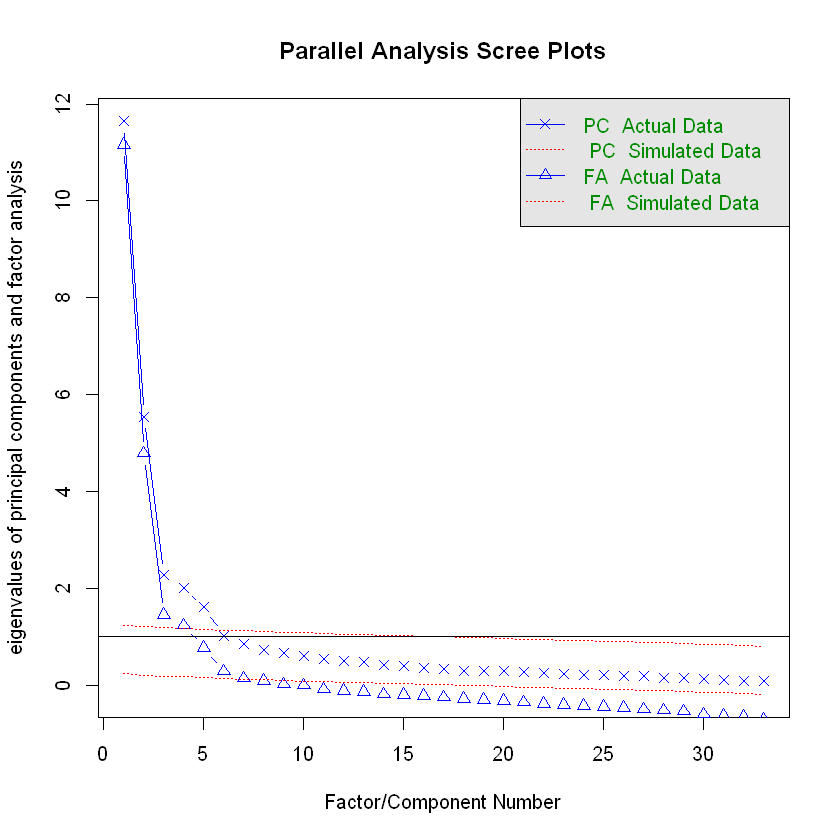

Warning message in min(x$vss.stats[, "BIC"], na.rm = TRUE):
"min里所有的参数都不存在; 回覆Inf"
Warning message in min(x$vss.stats[, "SABIC"], na.rm = TRUE):
"min里所有的参数都不存在; 回覆Inf"



Very Simple Structure
Call: vss(x = corSpearman_favee, n = 11, fm = "pc", n.obs = 2385)
VSS complexity 1 achieves a maximimum of 0.74  with  1  factors
VSS complexity 2 achieves a maximimum of 0.91  with  2  factors

The Velicer MAP achieves a minimum of 0.02  with  6  factors 
BIC achieves a minimum of  Inf  with    factors
Sample Size adjusted BIC achieves a minimum of  Inf  with    factors

Statistics by number of factors 
   vss1 vss2   map dof chisq prob sqresid  fit RMSEA BIC SABIC complex eChisq
1  0.74 0.00 0.070   0    NA   NA    47.5 0.74    NA  NA    NA      NA     NA
2  0.66 0.91 0.027   0    NA   NA    16.8 0.91    NA  NA    NA      NA     NA
3  0.58 0.89 0.024   0    NA   NA    11.6 0.94    NA  NA    NA      NA     NA
4  0.57 0.85 0.021   0    NA   NA     7.6 0.96    NA  NA    NA      NA     NA
5  0.50 0.85 0.015   0    NA   NA     5.1 0.97    NA  NA    NA      NA     NA
6  0.51 0.80 0.015   0    NA   NA     4.0 0.98    NA  NA    NA      NA     NA
7  0.49 0.79 0.018   0 

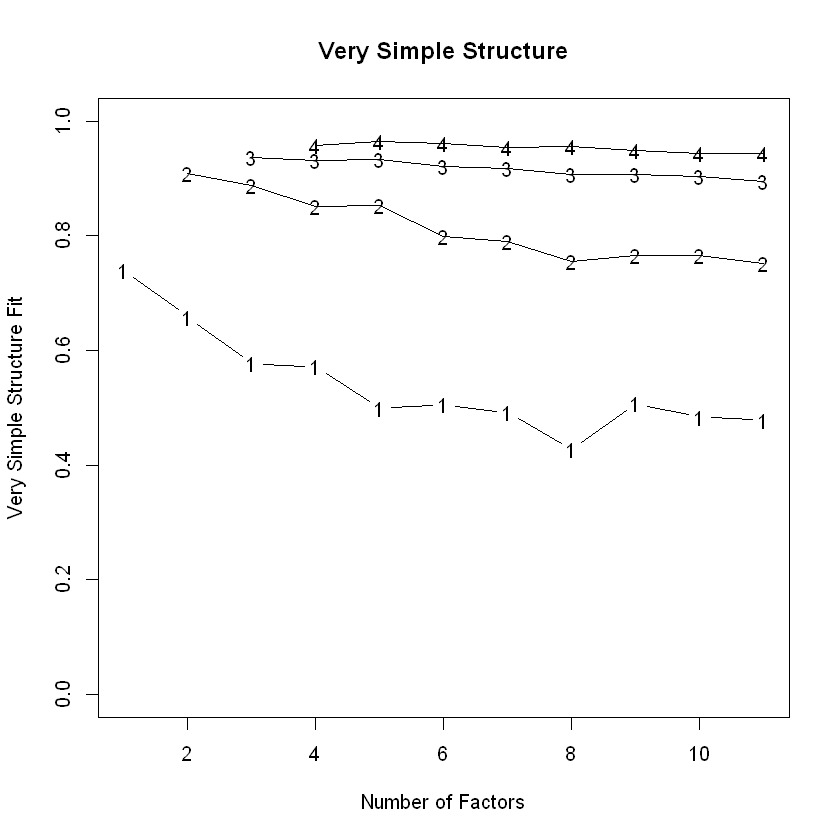

In [9]:
# data processing
favee <- read.csv("input_global/region_15_all_scaled_2385r.csv")
corSpearman_favee<-cor(favee[, c(2:34)], method=c("pearson"))
corSpearman_favee<- as.data.frame(corSpearman_favee)
corSpearman_favee = cbind(data.frame(row.names(corSpearman_favee)),corSpearman_favee) 
row.names(corSpearman_favee) <- NULL
# here we go!
row.names(corSpearman_favee) <- corSpearman_favee[, 1]
corSpearman_favee <-
  corSpearman_favee[, c(2:34)] #drop row names read in as a variable
corSpearman_favee <- as.matrix(corSpearman_favee)

#look at number of components to extract
fa.parallel(corSpearman_favee, n.obs = 2385) #says 8 factors or 5 components.
vss <- vss(corSpearman_favee,
           n = 11,
           fm = "pc",
           n.obs = 2385)
vss #MAP achieves a minimum of 0.01  with  5 factors

ba_FAVEE <- extended_bassAckward(corSpearman_favee, num.comp = 11, fm = "fa")#as described in-text, we end up with a 10-level hierarchy

In [10]:
ba_FAVEE$comp.corr #correlations between all levels

[[1]]
          b1        b2
a1 0.8674313 -0.653022

[[2]]
          c1        c2           c3
a1 0.8326647 0.7765669 -0.005162244

[[3]]
           c1         c2        c3
b1  0.5529306  0.9201040 0.3157196
b2 -0.8794480 -0.1629019 0.5380873

[[4]]
          d1         d2        d3         d4
a1 0.9240513 -0.2819402 0.5812318 -0.3916502

[[5]]
           d1        d2          d3         d4
b1  0.8870543 0.1044309  0.70702666 -0.1034719
b2 -0.5247580 0.7798838 -0.09850666  0.6737593

[[6]]
          d1          d2         d3          d4
c1 0.7594106 -0.52622782 0.22631518 -0.68292042
c2 0.7779410  0.08802839 0.80240200  0.08640726
c3 0.1590852  0.81920406 0.06665609  0.18625656

[[7]]
          e1        e2         e3        e4        e5
a1 0.8278337 0.6144333 -0.3132916 0.5783924 0.4094334

[[8]]
           e1         e2         e3         e4         e5
b1  0.9134388  0.2914753 0.03054458  0.6662373  0.3066177
b2 -0.2748946 -0.8406125 0.72682142 -0.1587431 -0.3725685

[[9]]
          e1         e2          e3          e4         e5
c1 0.5436670  0.8596374 -0.48595943 0.261371599 0.47476438
c2 0.8545314  0.1078525 -0.01783822 0.758419829 0.18215461
c3 0.3020186 -0.2695923  0.80081417 0.002376479 0.05719245

[[10]]
             e1          e2          e3          e4          e5
d1  0.907746358  0.53476094 -0.17520158  0.45201578  0.29266055
d2  0.065175400 -0.55963233  0.86167868 -0.01199174 -0.04672035
d3  0.524772577  0.01123364 -0.02934151  0.88757188  0.28211650
d4 -0.005503676 -0.71261994  0.29573677 -0.05244359 -0.64693186

[[11]]
          f1        f2        f3         f4        f5        f6
a1 0.8735576 0.6480257 0.5802184 -0.2633944 0.3134583 0.3220559

[[12]]
           f1          f2         f3         f4        f5         f6
b1  0.6394463  0.79876334  0.6693225 0.07470207 0.5493489  0.2148486
b2 -0.8196542 -0.08934202 -0.1584493 0.69647820 0.2411365 -0.3345992

[[13]]
           f1        f2          f3          f4          f5         f6
c1  0.9317255 0.3817256 0.263669145 -0.44526445 -0.07513582 0.40990631
c2  0.4856528 0.7279324 0.759825031  0.02036761  0.64011685 0.09938930
c3 -0.1432300 0.4424213 0.007332665  0.80776153  0.30488588 0.03028735

[[14]]
           f1         f2           f3           f4        f5          f6
d1  0.8260030 0.75868127  0.454869281 -0.127997666 0.4080743  0.19864003
d2 -0.4661165 0.24409912 -0.008404673  0.853616704 0.3022291 -0.04565326
d3  0.2790093 0.43131192  0.887656128 -0.003382824 0.4326495  0.22920519
d4 -0.5681221 0.03908555 -0.055868140  0.276558115 0.4575900 -0.63533794

[[15]]
           f1        f2          f3          f4           f5         f6
e1  0.6326377 0.8287553  0.46464983  0.01479968  0.616242725  0.1235570
e2  0.8360151 0.1375843  0.12817656 -0.38341194 -0.371104867  0.2374372
e3 -0.4104692 0.1561315 -0.03623248  0.89642904  0.114172864 -0.1551387
e4  0.3300975 0.3652205  0.93403543 -0.01729279  0.300079242  0.1150742
e5  0.3537007 0.1949913  0.17568440 -0.13008706 -0.009199694  0.8856479

[[16]]
          g1       g2        g3         g4        g5        g6        g7
a1 0.8519179 0.657401 0.5702366 -0.2716044 0.7308417 0.2241426 0.3505147

[[17]]
           g1          g2         g3         g4         g5        g6         g7
b1  0.6473908  0.80498071  0.6609513 0.06929947  0.5398742 0.4923168  0.2443986
b2 -0.7654092 -0.09861586 -0.1501417 0.70279313 -0.6693385 0.3405008 -0.3477162

[[18]]
           g1        g2          g3          g4          g5         g6
c1  0.8508784 0.3918725 0.254271064 -0.45855676 0.813884351 -0.1740916
c2  0.5424165 0.7328789 0.753127597  0.02230009 0.362362470  0.5933159
c3 -0.1918013 0.4398982 0.008488024  0.79542716 0.001889589  0.3502137
           g7
c1 0.42993895
c2 0.12757044
c3 0.03495441

[[19]]
           g1         g2          g3           g4         g5        g6
d1  0.8052341 0.76539063  0.44436509 -0.140488846  0.7087941 0.3283542
d2 -0.4751776 0.23898197 -0.00385417  0.849881805 -0.3043320 0.3765665
d3  0.3340578 0.438

In [11]:
ba_FAVEE$cong #congruence coefficients between all levels

[[1]]
     b1    b2
a1 0.85 -0.61

[[2]]
     c1   c2   c3
a1 0.81 0.73 0.01

[[3]]
      c1   c2   c3
b1  0.44 0.91 0.38
b2 -0.87 0.00 0.56

[[4]]
     d1    d2  d3    d4
a1 0.91 -0.25 0.5 -0.35

[[5]]
      d1   d2   d3    d4
b1  0.86 0.22 0.63 -0.03
b2 -0.43 0.81 0.00  0.63

[[6]]
     d1    d2    d3    d4
c1 0.73 -0.43  0.04 -0.71
c2 0.68  0.09  0.80  0.24
c3 0.25  0.92 -0.09 -0.01

[[7]]
     e1  e2    e3   e4   e5
a1 0.81 0.6 -0.26 0.51 0.34

[[8]]
      e1    e2   e3    e4    e5
b1  0.90  0.21 0.15  0.60  0.24
b2 -0.17 -0.82 0.73 -0.06 -0.28

[[9]]
     e1    e2    e3    e4   e5
c1 0.48  0.89 -0.36  0.09 0.45
c2 0.79 -0.04 -0.02  0.75 0.06
c3 0.34 -0.13  0.90 -0.12 0.20

[[10]]
     e1    e2    e3    e4    e5
d1 0.94  0.51 -0.09  0.25  0.17
d2 0.11 -0.45  0.94 -0.04  0.13
d3 0.32 -0.10 -0.04  0.95  0.26
d4 0.10 -0.70  0.08 -0.03 -0.75

[[11]]
     f1   f2  f3    f4   f5   f6
a1 0.84 0.58 0.5 -0.21 0.27 0.26

[[12]]
      f1   f2    f3   f4   f5    f6
b1  0.54 0.74  0.61 0.18 0.53  0.16
b2 -0.77 0.02 -0.03 0.68 0.29 -0.24

[[13]]
      f1   f2    f3    f4    f5   f6
c1  0.93 0.31  0.07 -0.31 -0.17 0.38
c2  0.33 0.61  0.76  0.00  0.65 0.00
c3 -0.04 0.46 -0.10  0.89  0.18 0.16

[[14]]
      f1   f2    f3    f4   f5    f6
d1  0.81 0.73  0.25 -0.05 0.38  0.08
d2 -0.39 0.29 -0.01  0.91 0.22  0.13
d3  0.09 0.22  0.96 -0.03 0.35  0.24
d4 -0.51 0.09 -0.02  0.05 0.53 -0.73

[[15]]
      f1   f2   f3    f4    f5    f6
e1  0.58 0.80 0.27  0.03  0.62  0.04
e2  0.87 0.07 0.05 -0.19 -0.47  0.10
e3 -0.28 0.18 0.01  0.98 -0.01 -0.01
e4  0.19 0.15 1.00  0.01  0.18  0.06
e5  0.21 0.15 0.10  0.01 -0.03  0.99

[[16]]
    g1   g2  g3    g4   g5   g6   g7
a1 0.8 0.59 0.5 -0.24 0.63 0.19 0.29

[[17]]
      g1   g2    g3   g4    g5   g6    g7
b1  0.55 0.74  0.60 0.16  0.41 0.49  0.19
b2 -0.68 0.00 -0.05 0.70 -0.57 0.38 -0.26

[[18]]
      g1   g2    g3    g4   g5    g6   g7
c1  0.77 0.33  0.08 -0.35 0.76 -0.26 0.40
c2  0.43 0.61  0.75  0.00 0.17  0.61 0.03
c3 -0.14 0.45 -0.11  0.87 0.12  0.22 0.16

[[19]]
      g1   g2    g3    g4    g5   g6    g7
d1  0.75 0.74  0.24 -0.08  0.64 0.31  0.10
d2 -0.42 0.27 -0.03  0.91 -0.19 0.29  0.12
d3  0.19 0.21  0.96 -0.02 -0.02 0.33  0.26
d4 -0.33 0.08 -0.03  0.07 -0.49 0.57 -0.73

[[20]]
      g1   g2   g3    g4    g5    g6    g7
e1  0.59 0.81 0.26  0.01  0.43  0.57  0.07
e2  0.68 0.10 0.06 -0.22  0.76 -0.54  0.12
e3 -0.36 0.17 0.00  0.97 -0.07  0.06 -0.02
e4  0.26 0.15 1.00  0.02  0.09  0.16  0.08
e5  0.14 0.15 0.10  0.00  0.19 -0.05  0.99

[[21]]
      g1   g2   g3    g4    g5    g6    g7
f1  0.85 0.27 0.17 -0.22  0.84 -0.07  0.16
f2  0.27 1.00 0.18  0.08  0.15  0.24  0.09
f3  0.24 0.19 1.00  0.03  0.06  0.17  0.09
f4 -0.28 0.08 0.01  0.99  0.03  0.14  0.00
f5  0.15 0.26 0.18  0.07 -0.04  0.99 -0.02
f6  0.07 0.07 0.07  0.00  0.13 -0.05  1.00

[[22]]
    h1   h2   h3    h4   h5    h6   h7   h8
a1 0.5 0.76 0.55 -0.53 0.62 -0.23 0.27 0.26

[[23]]
      h1    h2   h3    h4    h5   h6    h7   h8
b1  0.61  0.68 0.71 -0.15  0.42 0.14  0.18 0.49
b2 -0.03 -0.42 0.02  0.79 -0.54 0.65 -0.25 0.25

[[24]]
      h1   h2   h3    h4   h5    h6   h7    h8
c1  0.07 0.63 0.30 -0.69 0.74 -0.32 0.38 -0.16
c2  0.76 0.54 0.58 -0.09 0.18 -0.01 0.02  0.62
c3 -0.09 0.11 0.45  0.46 0.16  0.81 0.16  0.11

[[25]]
      h1    h2   h3    h4    h5    h6    h7   h8
d1  0.25  0.79 0.70 -0.38  0.63 -0.09  0.09 0.35
d2 -0.01 -0.13 0.28  0.66 -0.14  0.85  0.13 0.15
d3  0.96  0.23 0.20 -0.08 -0.02 -0.02  0.25 0.34
d4 -0.02 -0.18 0.08  0.45 -0.48  0.06 -0.72 0.52

[[26]]
     h1    h2   h3    h4    h5    h6    h7    h8
e1 0.27  0.73 0.77 -0.14  0.44 -0.03  0.06  0.57
e2 0.04  0.45 0.08 -0.74  0.73 -0.16  0.11 -0.43
e3 0.01 -0.15 0.18  0.52 -0.03  0.94 -0.01 -0.05
e4 0.99  0.23 0.14 -0.20  0.08  0.05  0.07  0.20
e5 0.11  0.17 0.15 -0.07  0.20 -0.05  0.99 -0.07

[[27]]
     h1    h2   h3    h4    h5    h6    h7    h8
f1 0.15  0.72 0.23 -0.67  0.82 -0.19  0.14  0.03
f2 0.19  0.43 0.99  0.00  0.16  0.04  0.08  0.21
f3 0.99  0.23 0.17 -0.17  0.06  0

In [12]:
# Level2
level2<-ba_FAVEE$comp.load[[2]]#component loadings at each level [[x]] specified level 'x'
loadings_var = as.data.frame(level2[,])
colnames(loadings_var) = c('Gemeinschaft','Gesellschaft')
write.csv(loadings_var,file='./output_bassackwards/Forbes_level2.csv')
# Level3
level3<-ba_FAVEE$comp.load[[3]]#component loadings at each level [[x]] specified level 'x'
loadings_var = as.data.frame(level3[,])
colnames(loadings_var) = c('Formality','Gemeinschaft','Exchange')
write.csv(loadings_var,file='./output_bassackwards/Forbes_level3.csv')
# Level4
level4<-ba_FAVEE$comp.load[[4]]#component loadings at each level [[x]] specified level 'x'
loadings_var = as.data.frame(level4[,])
colnames(loadings_var) = c('Activeness','Exchange','Valence','Formality')
write.csv(loadings_var,file='./output_bassackwards/Forbes_level4.csv')
# Level5
level5<-ba_FAVEE$comp.load[[5]]#component loadings at each level [[x]] specified level 'x'
loadings_var = as.data.frame(level5[,])
colnames(loadings_var) = c('Activeness','Formality','Exchange','Valence','Equality')
write.csv(loadings_var,file='./output_bassackwards/Forbes_level5.csv')

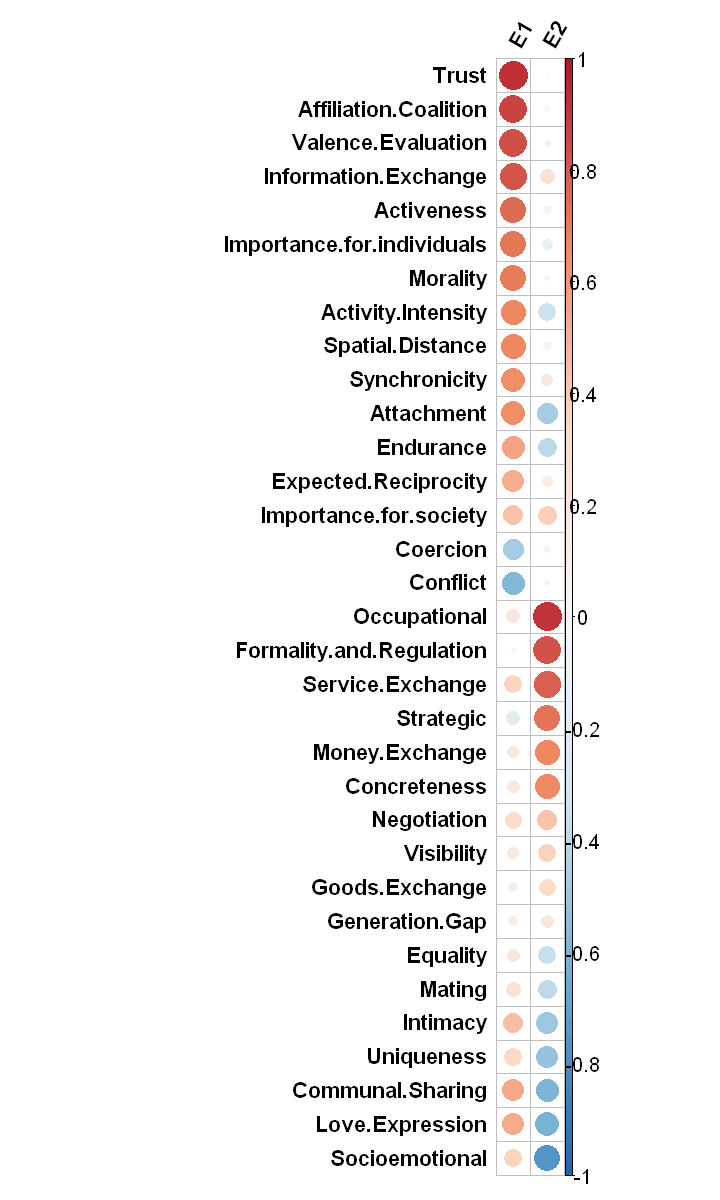

In [13]:
level2<-ba_FAVEE$comp.load[[2]]
loadings_var = as.data.frame(level2[,])
loadings_var_reorder = as.data.frame(loadings_var[,1:2])
colnames(loadings_var_reorder) = c('E1','E2')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:2)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(E1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(E2))

loadings_var_reorder = rbind(RC1,RC2)
loadings_var_reorder = loadings_var_reorder[1:2]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1.0,1.0,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1.0,1.0),cl.ratio = 0.8,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

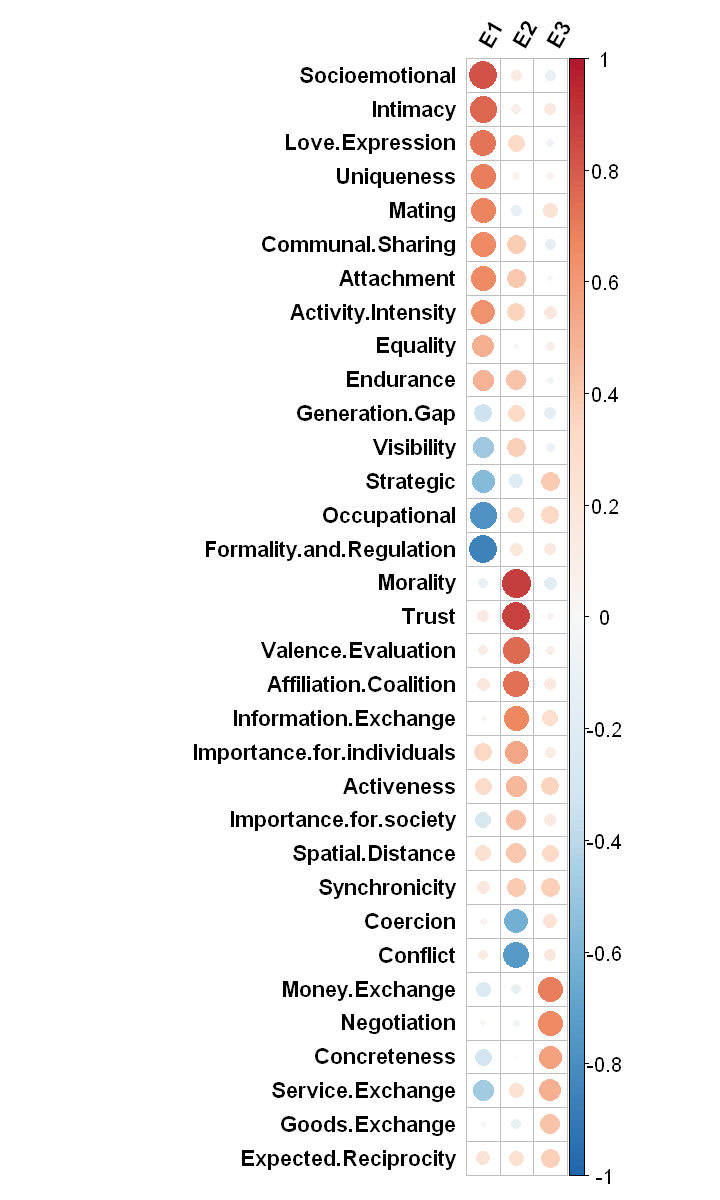

In [14]:
level3<-ba_FAVEE$comp.load[[3]]
loadings_var = as.data.frame(level3[,])
loadings_var_reorder = as.data.frame(loadings_var[,1:3])
colnames(loadings_var_reorder) = c('E1','E2','E3')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:3)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(E1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(E2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(E3))

loadings_var_reorder = rbind(RC1,RC2,RC3)
loadings_var_reorder = loadings_var_reorder[1:3]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1.0,1.0,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1.0,1.0),cl.ratio = 0.8,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

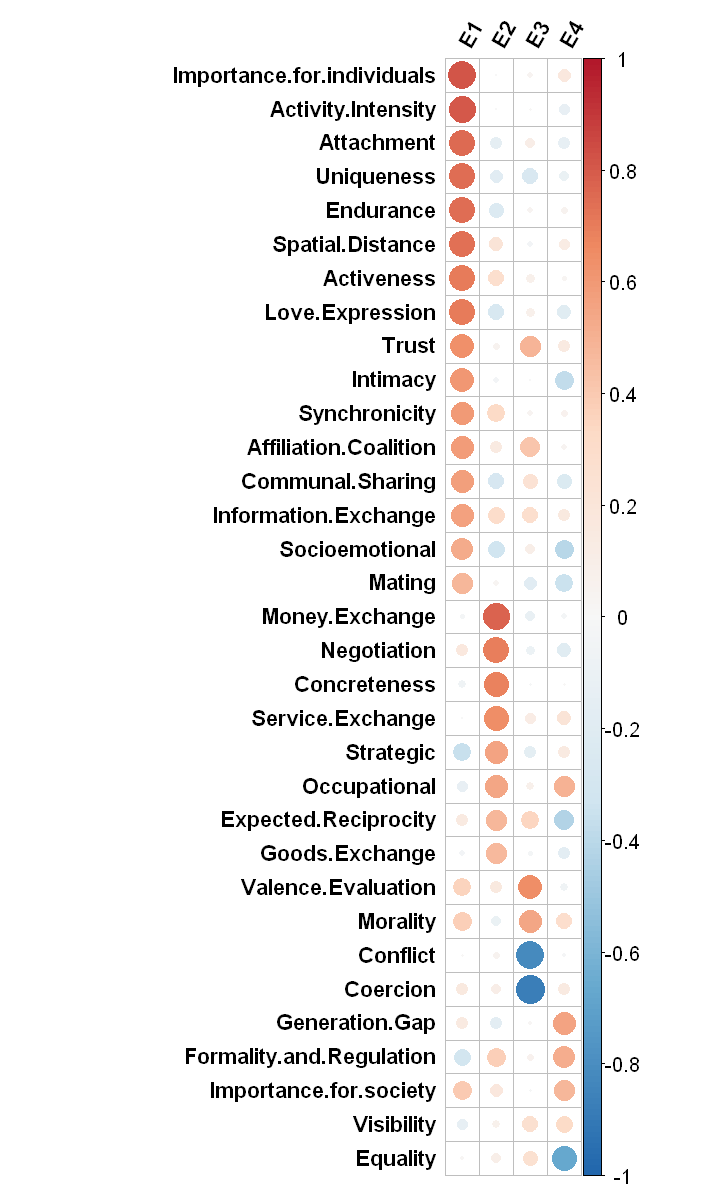

In [15]:
level4<-ba_FAVEE$comp.load[[4]]
loadings_var = as.data.frame(level4[,])
loadings_var_reorder = as.data.frame(loadings_var[,1:4])
colnames(loadings_var_reorder) = c('E1','E2','E3','E4')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:4)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(E1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(E2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(E3))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(E4))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4)
loadings_var_reorder = loadings_var_reorder[1:4]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1.0,1.0,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1.0,1.0),cl.ratio = 0.6,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

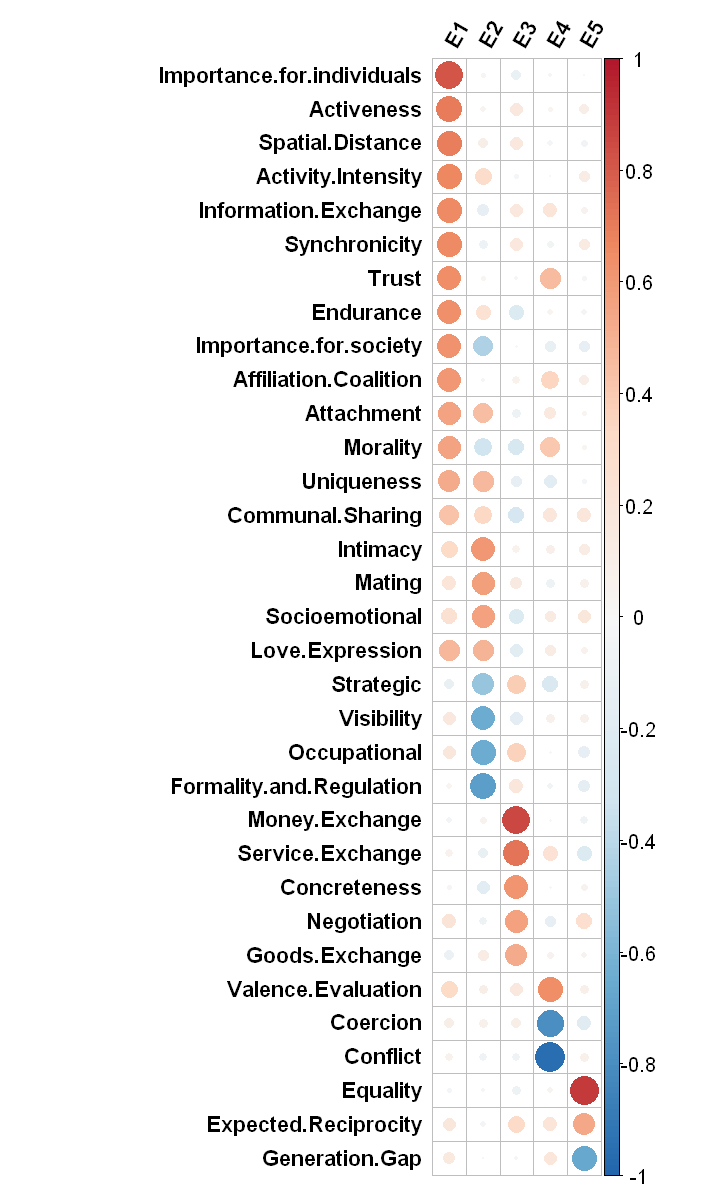

In [16]:
level5<-ba_FAVEE$comp.load[[5]]
loadings_var = as.data.frame(level5[,])
loadings_var_reorder = as.data.frame(loadings_var[,1:5])
colnames(loadings_var_reorder) = c('E1','E2','E3','E4','E5')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(E1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(E2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(E3))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(E4))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(E5))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1.0,1.0,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1.0,1.0),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

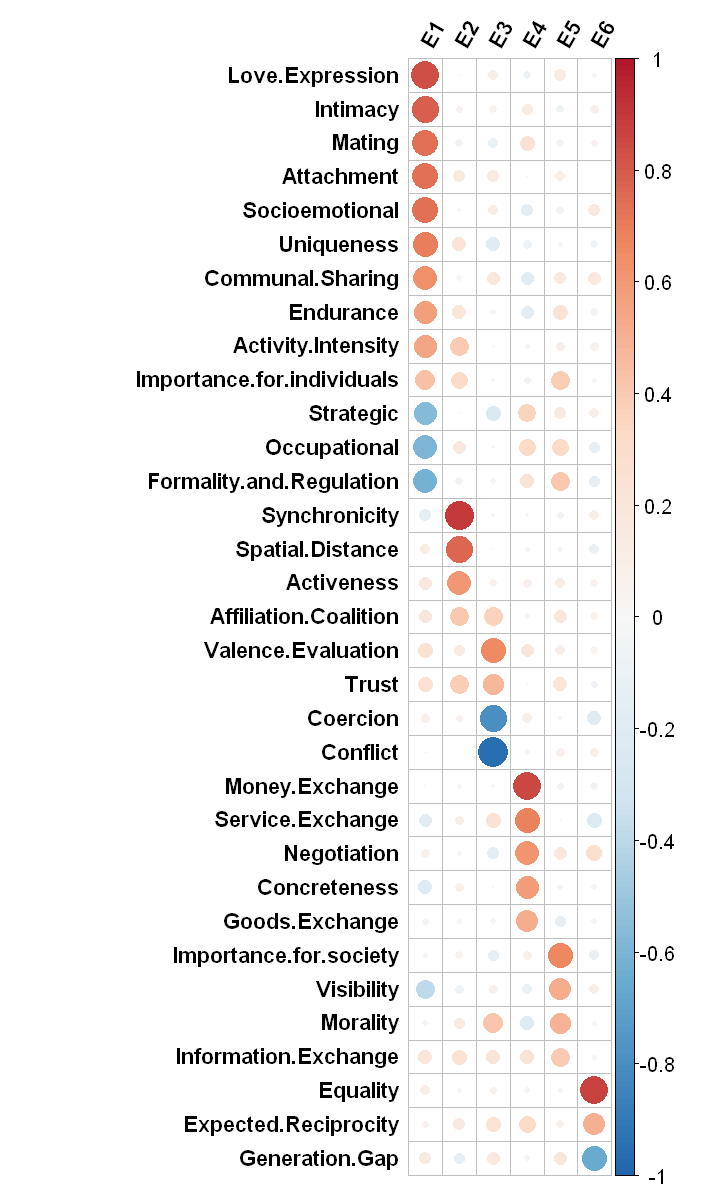

In [17]:
level6<-ba_FAVEE$comp.load[[6]]
loadings_var = as.data.frame(level6[,])
loadings_var_reorder = as.data.frame(loadings_var[,1:6])
colnames(loadings_var_reorder) = c('E1','E2','E3','E4','E5','E6')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:6)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(E1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(E2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(E3))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(E4))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(E5))
RC6 = loadings_var_reorder %>% filter(order==6) %>% arrange(desc(E6))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5,RC6)
loadings_var_reorder = loadings_var_reorder[1:6]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1.0,1.0,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1.0,1.0),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

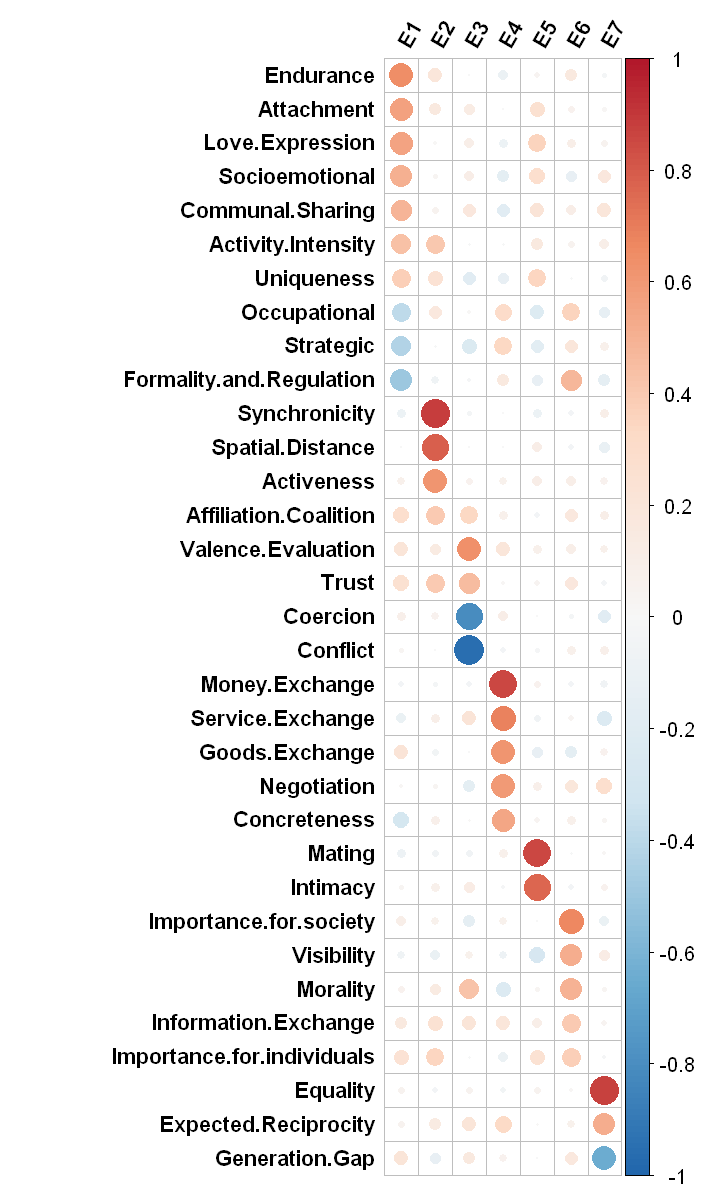

In [18]:
level7<-ba_FAVEE$comp.load[[7]]
loadings_var = as.data.frame(level7[,])
loadings_var_reorder = as.data.frame(loadings_var[,1:7])
colnames(loadings_var_reorder) = c('E1','E2','E3','E4','E5','E6','E7')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:7)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(E1))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(E2))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(E3))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(E4))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(E5))
RC6 = loadings_var_reorder %>% filter(order==6) %>% arrange(desc(E6))
RC7 = loadings_var_reorder %>% filter(order==7) %>% arrange(desc(E7))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5,RC6,RC7)
loadings_var_reorder = loadings_var_reorder[1:7]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1.0,1.0,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1.0,1.0),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))